# Practical on soil and organic carbon erosion at the global scale

## Installation of Python with Anaconda and necessary packages  


1)	Install Anaconda with python 2.7 (ideally): http://docs.continuum.io/anaconda/install/  

2)	Install fortran compilers to run f2py in Anaconda  

    For Windows:  
    I.	Download and install MinGW-w64  through the anaconda prompt: conda install mingw  
    II.	Insert the path to the mingw bin folder to your system path. The path that you want to add to your system variable should look something like C:\mingw\mingw64\bin. Go to control panel > advanced system settings > environmental variables > system variables > add new > variable is gfortran.exe and path is C:\Users\adminuser\Anaconda2\MinGW\bin  
    III.	In Anaconda create the environment in which you want f2py working, and activate it:  
            conda create -n py36_test python=3.6  
            activate py36_test  
    VI.	Configure your Anaconda environment to use MinGW when it compiles by executing the command below from the Anaconda prompt: (echo [build] & echo compiler = mingw32) > CONDA_PREFIX%\Lib\distutils\distutils.cfg  
    VIII.	Install several necessary packages to your environment: conda install numpy libpython m2w64-toolchain  
    
    For Linux :  
    Just make sure numpy is installed, which should be the case when you have installed anaconda. And install gfortran: apt install gfortran  
    
    For Mac:  
    Just make sure numpy is installed, which should be the case when you have installed anaconda. And install gcc: apt install gcc  
    
3)	Launch spyder from py27_test environment in which you want to work. Run the command: spyder activate py27_test  
    You can also open the anaconda-navigator and change the environment from “base” to “py27_test”. Then launch spyder  
    
4)	Launch spyder, then go to tools>preferences>Ipython console>graphics>change “backend” to Automatic  

5)	Install Basemap: conda install -c conda-forge basemap  

**Important!**  
-->  If the ‘run’ command in spyder does not work, run your script in the IPython console with the following command:   execfile(‘file.py’). Make sure that you are in the directory where your python file is stored or go to that directory by doing: cd  ‘path to file’  
-->  If the IPython console freezes while running a script, just restart the console. This can happen after plotting results for example.  


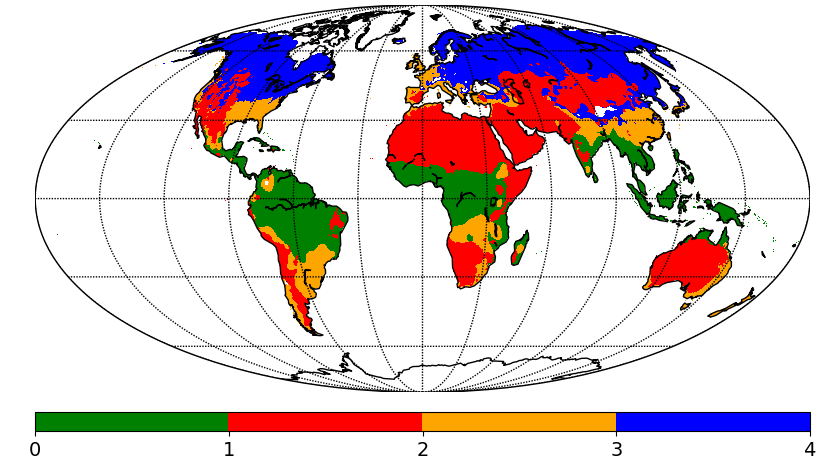

In [11]:
from IPython.display import Image
Image("clim_class.png")

**Fig 1: Major climate classification zones according the Koeppen-Geiger climate classification system. Zone A (green): Tropical; Zone B (red): Arid/Dry; Zone C (yellow): Temperate; Zone D (blue): Cold**

The aim of this practical is to have an idea of how coarse-resolution global models of soil loss and land surface processes can be used to study the soil organic carbon pool. We will make use of the CE-DYNAM model that I have introduced before, and will only look at the carbon erosion rates triggered by soil removal on cropland. 
The practical session will consist out of 2 parts. In the first part we will calculate soil erosion rates by rainfall on cropland using the Adjusted Revised Soil Loss Equation model (Adj. RUSLE) as in Naipal et al., 2015. In the second part we will couple these erosion rates to the carbon cycle of ORCHIDEE by using the carbon emulator (Naipal et al., 2018) to estimate the potential loss of soil organic carbon by erosion on cropland. We will also look at the role of global changes such as land use change and climate change on the soil and C erosion rates. Finally, at the end of both practicals we will compare the results for the different climate zones to see how erosion rates on cropland differ.


### Practical 1: Water erosion on cropland

The idea of this practical is to study the changes in potential soil erosion rates on cropland in regions with different climate zones, and discuss the contribution of land use change versus climate change to the temporal trends over the period 1975-2005.  

1)	Calculate soil erosion rates for three different setups:   
    a.	Land use change and climate change both activated  
    b.	Land use change only activated  
    c.	Climate change only activated  

Download and unzip the Erosion-practical file. Move/Copy the folders that are in this file to your work directory. In your work directory create an empty ‘output’ directory, where your will store the results of the model. In the output directory create empty directory ‘erosion’, and within ‘erosion’ 2 empty directories ‘CC’ and ‘LUC’.  

Now launch spyder in your created environment.  

For windows: Open Anaconda prompt and type: spyder activate py27_test (or py36_test)  

For Linux/Mac: Open a terminal and type spyder activate py27_test (or py36_test)  

In spyder open the file ‘erosion_run.py’. Here you have to change the workdir to your work directory, the clim_sel to the climatic zone that you are investigating (1=A, 2=B, 3=C, 4=D) and the simulation setup: ‘LUC’ for land use change-only, ‘CC’ for climate change only and ‘CC+LUC’ for land use change and climate change. You will have to run all three simulations.  

However, before running erosion_run.py you need to create a python module ‘erosion’ from the erosion.f90 script. To do this you have to open another anaconda prompt if you have windows and activate your environment (conda activate py27_test) or in linux just open another terminal.  

Then navigate to the E_code directory that contains the run files. Execute the following command: f2py –c –m erosion erosion.f90  

This will compile the fortran code and create a file erosion.so or erosion.pyd, depending if you have windows or linux. 
Now you go back to spyder and run the file erosion_run.py with selected input as mentioned before. To run the file simply click the green arrow or in the IPython console navigate to the E_code directory and type execfile(‘erosion_run.py’)


In [12]:
# -*- coding: utf-8 -*-
import numpy as np
from netCDF4 import Dataset
import sys
sys.path.insert(0,'C:\VIKA\Postdoc_LSCE\Indices\E_code')
import erosion

###########################################
#This script calculates global yearly average soil erosion rates
#Transient simulation = changing land use and climate (CC+LUC), changing climate only (CC),
#or changing land use only (LUC)
#Equilibrium simulation = average soil erosion rates for a specific period
#When using this model code please cite: "Naipal ,V., Ciais, P., Wang, Y., Lauerwald, R.,
#Guenet, B., Van Oost, K. (2018). Global soil organic carbon removal by water erosion under
#climate change and land use change during 1850–2005 AD. Biogeosciences, 15, 4459–4480,
#https://doi.org/10.5194/bg-15-4459-2018"
############################################

print ('start script')

#settings
workdir="C:\VIKA\Postdoc_LSCE\Indices" #Enter here your work directory
years=range(1975,2006) #transient period
simulation="CC+LUC" #select simulation type from: equilibrium,CC+LUC,CC,LUC
clim_class=("A","B","C","D")
clim_sel=1 #select climate classification: Zone A, B, C or D. Choose from: 1, 2, 3 or 4
lc=1 #select vegetation type crop, 0=tree, 2=grass, 3=bare
veget="crop" #select vegetation type tree,crop,grass or bare

rows=1680;kols=4322 #global 5 arcmin resolution grid

#general input data
data = Dataset('%s\input\climate_classification_aggr_5m.nc' % (workdir) ,'r') #climate zone data
clim= data.variables['climate'][:] #1= Zone A (tropical), 2= Zone B (arid/dry), 3= Zone C (temperate), 4= Zone D (Cold)
clim[clim<0.]=np.nan
clim = np.ravel(clim)
data.close()  

data = Dataset('%s\input\S_scaled_5m.nc' % (workdir),'r') #S factor
S= data.variables['s'][:]
S[S<0.] = 0.
S[np.isnan(S)==True] = 0.
S=np.ravel(S)
S[clim!=clim_sel]=0.
data.close()

data = Dataset('%s\input\K_volcanic_nogravel_5m.nc' % (workdir),'r')
K = data.variables['k'][:] # K factor without gravel correction but with volcanic soil correction
K[K<0.] = 0.
K[np.isnan(K)==True] = 0.
K=np.ravel(K)
K[clim!=clim_sel]=0.
data.close()

data = Dataset('%s\input\gravel_topsoil_5m.nc' % (workdir),'r')
gravel = data.variables['GRAV'][:] # gravel content in %
gravel=gravel.astype(float)
gravel[gravel<0.] = 0.
gravel[np.isnan(gravel)==True] = 0.
gravel = np.ravel(gravel)
gravel[clim!=clim_sel]=0.
data.close()

print ('read input data part 1: done')

if simulation =='equilibrium':
  ####################################
  # Equilibrium 
  ###################################
  data0 = Dataset('%s\input\landcover\PFTmap_LUHv2_BM3_HoughtonCountryForestarea_crop_1975-1985_mean_5m.nc' % (workdir),'r') #crop fraction
  crop = data0.variables['maxvegetfrac'][0]
  crop[crop>1.] = np.nan;crop[crop<0.] = np.nan
  crop=np.nansum(crop,axis=0)
  crop[np.isnan(crop)==True] = 0.
  crop=np.ravel(crop)
  crop[clim!=clim_sel]=0.
  data0.close()

  data2 = Dataset('%s\input\R_factor\ISIMIP2b_R_1975-1985_mean_5m.nc' % (workdir),'r') # R factor
  R = data2.variables['r'][:] 
  R[R<0]=0.;R[R>10e35]=0.;R[np.isnan(R)==True] = 0.
  R=np.ravel(R)
  R[clim!=clim_sel]=0.
  data2.close()    

  nc = Dataset('%s\input\C_factor\C_crop_1975-1985_mean_5m.nc' % (workdir),'r') # C factor   
  C = nc.variables['c_lc'][:]
  C[C<0]=0.;C[np.isnan(C)==True] = 0.
  C=np.ravel(C)   
  C[clim!=clim_sel]=0.
  
  print ('read input data part 2: done')
  
  #calculate erosion for this timeperiod
  E=erosion.erosion.main(S,K,R,C,veget,crop,gravel,rows,kols)
  E = E.reshape(rows,kols)      
  #output
  output = Dataset('%s\output\erosion\E_%s_mean_1975-1985_zone%s.nc' % (workdir,veget,clim_class[clim_sel-1]),'w')
  output.createDimension('latitude',rows)
  output.createDimension('longitude',kols)
  var=output.createVariable('latitude','f',('latitude',))
  var[:]=[83.9917-n*0.08329773 for n in range(rows)]
  var=output.createVariable('longitude','f',('longitude',))
  var[:]=[-180.+n*0.0833 for n in range(kols)]
  output.createVariable('E','d',('latitude','longitude',))
  output.variables['E'][:] = E
  output.close()  

  print ('erosion output: done')
    
  nc.close()    

if simulation =='CC+LUC':
  ####################################
  # CC + LUC
  ###################################
  for t in years:
    data = Dataset('%s/input/R_factor/ISIMIP2b_R_%04i_5m.nc' % (workdir,t),'r') # R factor
    R = data.variables['r'][:] 
    R[R<0]=0.;R[R>10e35]=0.
    R[np.isnan(R)==True] = 0.
    R=np.ravel(R)
    data.close()    

    data = Dataset('%s/input/landcover/PFTmap_LUHv2_BM3_HoughtonCountryForestarea_crop_%04i_5m.nc' % (workdir,t),'r')  #crop fraction
    crop = data.variables['maxvegetfrac'][0]
    crop[crop>1.] = np.nan;crop[crop<0.] = np.nan
    crop=np.nansum(crop,axis=0)
    crop[np.isnan(crop)==True] = 0.
    crop=np.ravel(crop)
      
    data = Dataset('%s/input/C_factor/C_crop_%04i_5m.nc' % (workdir,t),'r')
    C = data.variables['c_lc'][:] # C factor for crop
    C[C<0]=0.
    C[np.isnan(C)==True] = 0.
    C=np.ravel(C)   
    data.close()
    
    #calculate erosion for this timeperiod
    E=erosion.erosion.main(S,K,R,C,veget,crop,gravel,rows,kols)
    E = E.reshape(rows,kols)
    
    #output 
    output = Dataset('%s/output/erosion/E_%s_%04i_zone%s.nc' % (workdir,veget,t,clim_class[clim_sel-1]),'w')
    output.createDimension('latitude',rows)
    output.createDimension('longitude',kols)
    var=output.createVariable('latitude','f',('latitude',))
    var[:]=[83.9917-n*0.08329773 for n in range(rows)]
    var=output.createVariable('longitude','f',('longitude',))
    var[:]=[-180.+n*0.0833 for n in range(kols)]
    output.createVariable('E','d',('latitude','longitude',))
    output.variables['E'][:] = E
    output.close() 

if simulation =='CC':
  ####################################
  # CC only (LUC=set to 1975-1985)
  ###################################
  data0 = Dataset('%s/input/landcover/PFTmap_LUHv2_BM3_HoughtonCountryForestarea_crop_1975-1985_mean_5m.nc' % (workdir),'r')  #crop fraction
  crop = data0.variables['maxvegetfrac'][0]
  crop[crop>1.] = np.nan;crop[crop<0.] = np.nan
  crop=np.nansum(crop,axis=0)
  crop[np.isnan(crop)==True] = 0.
  crop=np.ravel(crop)
  data0.close()

  for t in years:
    data2 = Dataset('%s/input/R_factor/ISIMIP2b_R_%04i_5m.nc' % (workdir,t),'r') # R factor
    R = data2.variables['r'][:] 
    R[R<0]=0.
    R[R>10e35]=0.
    R[np.isnan(R)==True] = 0.
    R=np.ravel(R)
    data2.close()    
      
    data1 = Dataset('%s/input/C_factor/CC/C_crop_%04i_5m.nc' % (workdir,t),'r') # C factor
    C = data1.variables['c_lc'][:]
    C[C<0]=0.;C[np.isnan(C)==True] = 0.
    C=np.ravel(C)   
      
    #calculate erosion for this timeperiod
    E=erosion.erosion.main(S,K,R,C,veget,crop,gravel,rows,kols)
    E = E.reshape(rows,kols)      
    #output
    output = Dataset('%s/output/erosion/CC/E_%s_%04i_zone%s.nc' % (workdir,veget,t,clim_class[clim_sel-1]),'w')
    output.createDimension('latitude',rows)
    output.createDimension('longitude',kols)
    var=output.createVariable('latitude','f',('latitude',))
    var[:]=[83.9917-n*0.08329773 for n in range(rows)]
    var=output.createVariable('longitude','f',('longitude',))
    var[:]=[-180.+n*0.0833 for n in range(kols)]
    output.createVariable('E','d',('latitude','longitude',))
    output.variables['E'][:] = E
    output.close()   

if simulation =='LUC':
  ####################################
  # LUC only (CC=set to 1975-1985)
  ###################################
  data0 = Dataset('%s/input/R_factor/ISIMIP2b_R_1975-1985_mean_5m.nc' % (workdir),'r') # R factor
  R = data0.variables['r'][:] 
  R[R<0]=0.;R[R>10e35]=0.
  R[np.isnan(R)==True] = 0.
  R=np.ravel(R)
  data0.close() 

  for t in years: 
    data1 = Dataset('%s/input/landcover/PFTmap_LUHv2_BM3_HoughtonCountryForestarea_crop_%04i_5m.nc' % (workdir,t),'r') #crop fraction
    crop = data1.variables['maxvegetfrac'][0]
    crop[crop>1.] = np.nan;crop[crop<0.] = np.nan
    crop=np.nansum(crop,axis=0)
    crop[np.isnan(crop)==True] = 0.
    crop=np.ravel(crop)
    data1.close()
    
    data1 = Dataset('%s/input/C_factor/LUC/C_crop_%04i_5m.nc' % (workdir,t),'r') # C factor
    C = data1.variables['c_lc'][:]
    C[C<0]=0.;C[np.isnan(C)==True] = 0.
    C=np.ravel(C)   
      
    #calculate erosion for this timeperiod
    E=erosion.erosion.main(S,K,R,C,veget,crop,gravel,rows,kols)
    E = E.reshape(rows,kols)      
    #output
    output = Dataset('%s/output/erosion/LUC/E_%s_%04i_zone%s.nc' % (workdir,veget,t,clim_class[clim_sel-1]),'w')
    output.createDimension('latitude',rows)
    output.createDimension('longitude',kols)
    var=output.createVariable('latitude','f',('latitude',))
    var[:]=[83.9917-n*0.08329773 for n in range(rows)]
    var=output.createVariable('longitude','f',('longitude',))
    var[:]=[-180.+n*0.0833 for n in range(kols)]
    output.createVariable('E','d',('latitude','longitude',))
    output.variables['E'][:] = E
    output.close()        



2)	Plot (A) soil erosion timeseries and (B) quantile box plot  

a. We start with looking at the timeseries of soil erosion under different forcing regarding the three different simulations. Open the script erosion_analysis.py. Under settings you can change the clim_sel variable to your climate zone, and the workdir to your directory. The go to exercise 2A. We will now run only exercise 2A and have a look at the results so comment out everything below this exercise by doing this:  
“ “ “
Code
“ “ “  
Please save the figure you get in your output directory. You can also use the command: plt.savefig(‘file.png‘)  


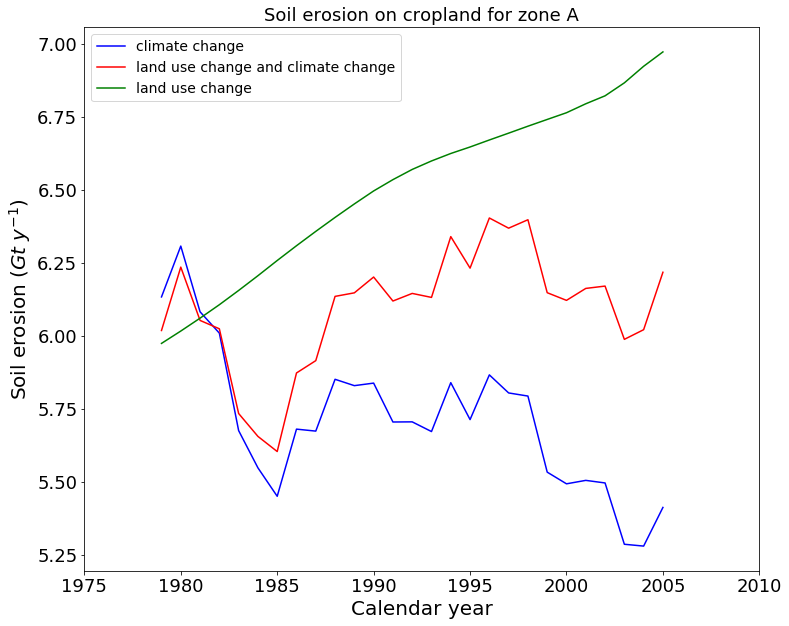

In [6]:
# -*- coding: utf-8 -*-
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
#check where basemap is installed on your system and modify the following line.
#In my case it's in: C:\\Users\\adminuser\\Anaconda2\\Library\\share
proj_lib = os.path.join(os.path.join(conda_dir, 'Library'), 'share') 
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

# function for moving average
def movingaverage(values,window):
  weights = np.repeat(1.0,window)/window
  smas = np.convolve(values,weights,'valid')
  return smas
#setting
years=range(1975,2006)
workdir='C:\VIKA\Postdoc_LSCE\Indices'
clim_class=("A","B","C","D")
clim_sel=1
rows=1680;kols=4322

# input datasets
data= Dataset('%s/input/Global_land_grid_area_5m_grid_ha.nc' % (workdir),'r')
A= data.variables['area'][:] #area of each pixel in ha
lats=np.array(data.variables['lat'][:])
lons=np.array(data.variables['lon'][:])
llons,llats=np.meshgrid(lons,lats)
A = np.ravel(A)
A[A<0.]=0.
data.close()

######################################
# Exercise 2A: Calculate and plot timeseries
######################################

E_cc_luc=[];E_cc=[];E_luc=[]
for y in range(len(years)):
  #print years[y]
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_zone%s.nc' % (workdir,years[y],clim_class[clim_sel-1]),'r')
  E_sum = np.array(data.variables['E'][:])
  E_sum[E_sum==0.]=np.nan
  E_sum[E_sum>100.]=np.nan #exclude unrealistic values
  E_sum=np.ravel(E_sum)*A
  E_cc_luc.append(np.nansum(E_sum)) #global total
  data.close()
  #erosion CC
  data = Dataset('%s/output/erosion/CC/E_crop_%04i_zone%s.nc' % (workdir,years[y],clim_class[clim_sel-1]),'r')
  E_sum = np.array(data.variables['E'][:])
  E_sum[E_sum==0.]=np.nan
  E_sum[E_sum>100.]=np.nan 
  E_sum=np.ravel(E_sum)*A
  E_cc.append(np.nansum(E_sum)) 
  data.close()  
  #erosion LUC
  data = Dataset('%s/output/erosion/LUC/E_crop_%04i_zone%s.nc' % (workdir,years[y],clim_class[clim_sel-1]),'r')
  E_sum = np.array(data.variables['E'][:])
  E_sum[E_sum==0.]=np.nan
  E_sum[E_sum>100.]=np.nan
  E_sum=np.ravel(E_sum)*A
  E_luc.append(np.nansum(E_sum)) 
  data.close()

E_cc_luc=np.asarray(E_cc_luc)*1E-9 #tonnes to Gt
E_cc=np.asarray(E_cc)*1E-9
E_luc=np.asarray(E_luc)*1E-9

#plotting-moving average
fig, ax = plt.subplots(figsize=(15,10))
fig.subplots_adjust(right=0.75)
ax.plot(years[len(years)-len(movingaverage(E_cc,5)):],movingaverage(E_cc,5),'b-',label='climate change')
ax.plot(years[len(years)-len(movingaverage(E_cc_luc,5)):],movingaverage(E_cc_luc,5),'r-',label='land use change and climate change')
ax.plot(years[len(years)-len(movingaverage(E_luc,5)):],movingaverage(E_luc,5),'g-',label='land use change')
ax.set_xlim([1975,2010])
#ax.set_ylim([2.,5..])
ax.set_xlabel('Calendar year',fontsize=20)
ax.set_ylabel('Soil erosion ($Gt$ $y^{-1}$)',fontsize=20)
ax.set_title('Soil erosion on cropland for zone %s' % (clim_class[clim_sel-1]),fontsize=18)
ax.tick_params('x',labelsize=18)
ax.tick_params('y',labelsize=18)
ax.legend(loc='upper left',fontsize=14)
plt.show()

b. Here we will compare how the average soil erosion for the specific climate zone changed between the start of the time 
period (1975-1985) and the end of the time period (1995-2005). For this we will plot a quantile boxplot that includes 
the following statistics: median, mean, 25th and 75th percentile and outliers. Go to exercise 2B and run that part. You 
can just select and copy the part you want to be executed and paste it into the IPython console. Save the figure you get. 


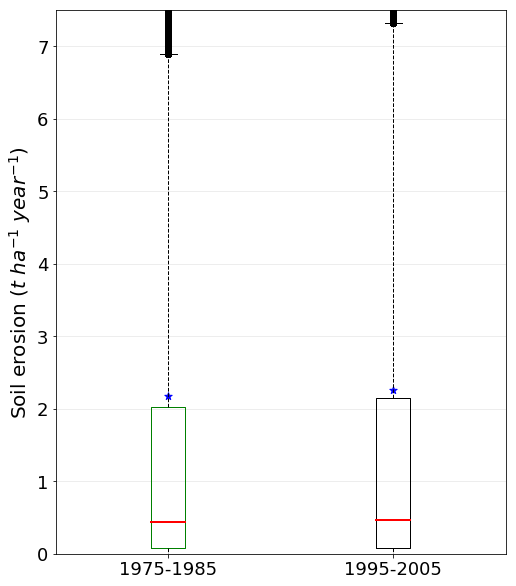

In [7]:
E0=0.;E1=0.
for y in range(1975,1985):
  print y
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_zone%s.nc' % (workdir,y,clim_class[clim_sel-1]),'r')
  E = np.array(data.variables['E'][:])
  E[E>20.]=20. #exclude unrealistic values
  E0+=np.ravel(E) #t/ha/y  
  data.close()
for y in range(1995,2005):
  print y
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_zone%s.nc' % (workdir,y,clim_class[clim_sel-1]),'r')
  E = np.array(data.variables['E'][:])
  E[E>20.]=20.
  E1+=np.ravel(E) 
  data.close()
E_1975_1985=E0/10.;E_1995_2005=E1/10.
E_1975_1985=E_1975_1985[E_1975_1985>0.001];E_1995_2005=E_1995_2005[E_1995_2005>0.001]

data=[E_1975_1985,E_1995_2005]
means=[np.mean(E_1975_1985),np.mean(E_1995_2005)]
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
ax.set_axisbelow(True)
bp=ax.boxplot(data,notch=0,vert=1,whis=2.5)
#ax.set_yscale('log')
for i in range(2):
  if i==0:
    plt.setp(bp['boxes'][i],color='g')
    plt.setp(bp['whiskers'][i],color='g')
    #plt.setp(bp['fliers'][i],color='g',marker='+')
  else:
    plt.setp(bp['boxes'][i],color='k')
    plt.setp(bp['whiskers'][i],color='k')
    #plt.setp(bp['fliers'][i],color='k',marker='+')
for median in bp['medians']:
  median.set(color='r',linewidth=2)
for whisker in bp['whiskers']:
  whisker.set(color='k',linestyle='--')
xtickNames=plt.setp(ax,xticklabels=np.array(['1975-1985','1995-2005']))
means_all=[means[0],means[1]]
plt.scatter(np.arange(1,3),means_all,color='b',marker='*',s=60)
ax.set_ylabel('Soil erosion ($t$ $ha^{-1}$ $year^{-1}$)',fontsize=20)
ax.set_ylim([0.,7.5])
ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis='x',labelsize=18)
plt.show()

c. If you have time you can also look at the histogram of the distribution of different erosion events by running ex. 2C. You can change the ax.set_ylim value to have a closer look at the frequencies. 

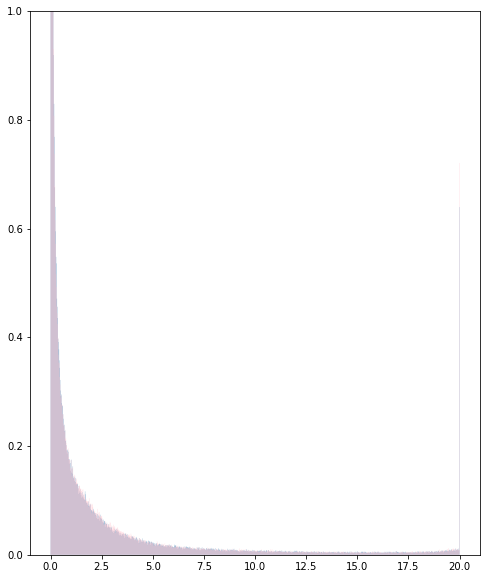

In [14]:
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.hist(E_1975_1985, bins=1000, normed=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
ax.hist(E_1995_2005, bins=1000, normed=True, alpha=0.5,
         histtype='stepfilled', color='pink',
         edgecolor='none')
ax.set_ylim([0.,1.])
plt.show()

3)	Plot worldmap of soil erosion  

To create a map of the spatial distribution of soil erosion over the globe we will use “Basemap” in python (exercise 3). You can plot either or both the means of the first period (1975-1985) or the last period (1995-2005) to see in which regions soil erosion might have changed and due to land use change or climate change. For this you can change the variable ‘data’ between E0/10 or E1/10. You can also play with the erosion due to land use change only or climate change only.


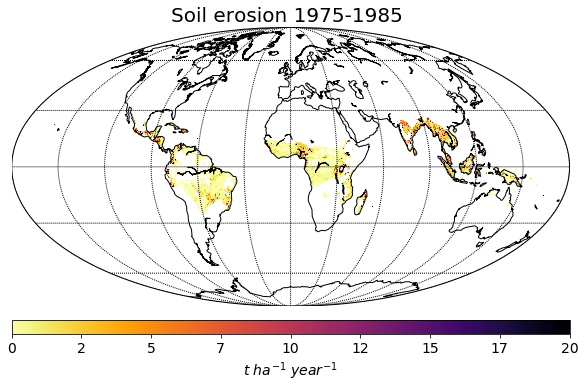

In [15]:
data=(E0/10.).reshape(rows,kols)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
m=Basemap(projection='moll',resolution='c', lon_0=0, llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=75.)
m.drawcoastlines()
m.drawparallels(np.arange(-60.,75.,30))
m.drawmeridians(np.arange(-180.,180.,30))
x,y=m(llons,llats)
cmap=plt.cm.inferno_r
data=np.ma.masked_where(data==0.,data)
cmap.set_bad('white')
cs=m.pcolormesh(x,y,data,vmin=0.,vmax=20.,cmap=cmap)
plt.title('Soil erosion 1975-1985 ',fontsize=20)
cbar = m.colorbar(cs,location='bottom',pad="5%",format='%i')
cbar.set_label('$t$ $ha^{-1}$ $year^{-1}$',fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.show()

### Practical 2: Carbon erosion on cropland  

During this part we will try to understand how much C is lost due to erosion on cropland in the different climatic zones, and study the role of the different global changes (land use change and climate change) in the loss fluxes during the period 1975-2005. As we do not have all the tools available to run the C emulator, based on the ORCHIDEE LSM, and we do not have so much time I have prepared the C erosion output files from my study published last year (Naipal et al., 2018).  

In this practical we will do the following:  

1)	(a) Plot timeseries and (b) the quantile box plot of C erosion rates per climate zone.  

We will use the C erosion rate files stored in SOC_data folder. You can have a look at the input of the data (format: Em_CE_cc_luc_1975.nc) if you have netcdf installed. It has 2 variables: E (carbon erosion in g/m2/year) and SOC (total SOC stock in g/m2 up to 2m depth).  
Open the file Cerosion_analysis.py and change the settings according to your previous specifications. Then execute exercise 1A and B, save the figures you get. If you have tile you can also do exercise 1C (commented out) in the same way as in part 1 of this practical.


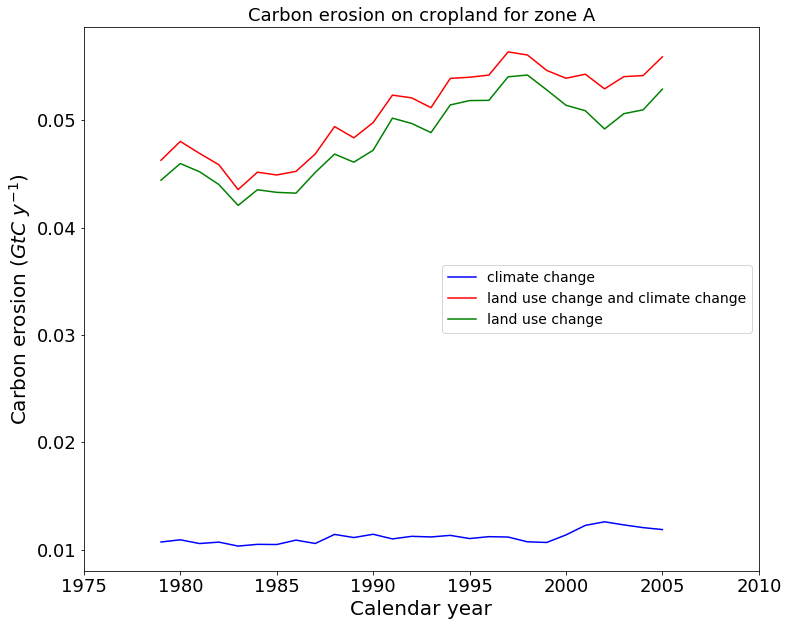

In [16]:
# -*- coding: utf-8 -*-
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
#check where basemap is installed on your system and modify the following line.
#In my case it's in: C:\\Users\\adminuser\\Anaconda2\\Library\\share
proj_lib = os.path.join(os.path.join(conda_dir, 'Library'), 'share') 
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
from PythonTools import *

# function for moving average
def movingaverage(values,window):
  weights = np.repeat(1.0,window)/window
  smas = np.convolve(values,weights,'valid')
  return smas
#setting
years=range(1975,2006)
workdir='C:\VIKA\Postdoc_LSCE\Indices'
clim_class=("A","B","C","D")
clim_sel=1 #zone A
rows=61;kols=96

data = Dataset('%s\input\climate_classification_aggr_coarse.nc' % (workdir) ,'r') #climate zone data
clim= data.variables['climate'][:61,:] #1= Zone A (tropical), 2= Zone B (arid/dry), 3= Zone C (temperate), 4= Zone D (Cold)
clim[clim<0.]=np.nan
data.close()  

nc=Dataset('%s/input/AREA_ORCHIDEE.nc' %(workdir),'r')
area=nc.variables['Areas'][:61,:-1]
contfrac=nc.variables['CONTFRAC'][:61,:-1]
AREA=area*contfrac
AREA[AREA<0.]=0.;AREA[abs(AREA)>1.e36]=0.
land=contfrac<=1.
lats=np.array(nc.variables['lat'][:61])
lons=np.array(nc.variables['lon'][:-1])
llons,llats=np.meshgrid(lons,lats)
nc.close()

######################################
# Exercise 1A: Calculate and plot timeseries
######################################
CE_cc_luc=[];CE_cc=[]
for y in range(len(years)):
  print years[y]
  #C erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,years[y]),'r')
  CE = np.array(data.variables['E'][:]) #g/m2
  CE[clim!=clim_sel]=0.
  CE_cc_luc.append(np.nansum(CE*AREA)) #global total
  data.close()
  #C erosion CC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_crop_%04i.nc' % (workdir,years[y]),'r')
  CE = np.array(data.variables['E'][:]) #g/m2
  CE[clim!=clim_sel]=0.
  CE_cc.append(np.nansum(CE*AREA)) #global total
  data.close()
  
CE_cc_luc=np.asarray(CE_cc_luc)*1E-15 #g to Pg
CE_cc=np.asarray(CE_cc)*1E-15
CE_luc=CE_cc[0]+(CE_cc_luc-CE_cc)

#plotting-moving average
fig, ax = plt.subplots(figsize=(15,10))
fig.subplots_adjust(right=0.75)
ax.plot(years[len(years)-len(movingaverage(CE_cc,5)):],movingaverage(CE_cc,5),'b-',label='climate change')
ax.plot(years[len(years)-len(movingaverage(CE_cc_luc,5)):],movingaverage(CE_cc_luc,5),'r-',label='land use change and climate change')
ax.plot(years[len(years)-len(movingaverage(CE_luc,5)):],movingaverage(CE_luc,5),'g-',label='land use change')
ax.set_xlim([1975,2010])
#ax.set_ylim([2.,5..])
ax.set_xlabel('Calendar year',fontsize=20)
ax.set_ylabel('Carbon erosion ($Gt C$ $y^{-1}$)',fontsize=20)
ax.set_title('Carbon erosion on cropland for zone %s' % (clim_class[clim_sel-1]),fontsize=18)
ax.tick_params('x',labelsize=18)
ax.tick_params('y',labelsize=18)
ax.legend(loc='middle right',fontsize=14)
plt.show()

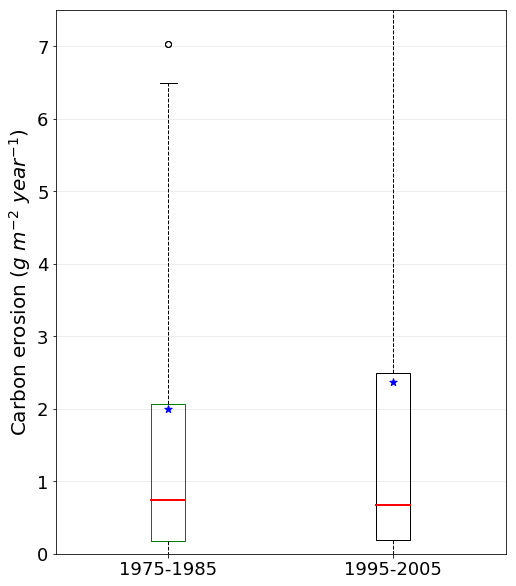

In [18]:
CE0=0.;CE1=0.
for y in range(1975,1985):
  print y
  #erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,y),'r')
  CE = np.array(data.variables['E'][:]) #g/m2
  CE[clim!=clim_sel]=0.  
  CE0+=np.ravel(CE) #g/m2/y  
  data.close()
for y in range(1995,2005):
  print y
  #erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,y),'r')
  CE = np.array(data.variables['E'][:]) #g/m2
  CE[clim!=clim_sel]=0.  
  CE1+=np.ravel(CE) 
  data.close()
CE_1975_1985=CE0/10.;CE_1995_2005=CE1/10.
CE_1975_1985=CE_1975_1985[CE_1975_1985>0.0001];CE_1995_2005=CE_1995_2005[CE_1995_2005>0.0001]

data=[CE_1975_1985,CE_1995_2005]
means=[np.mean(CE_1975_1985),np.mean(CE_1995_2005)]
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.yaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.5)
ax.set_axisbelow(True)
bp=ax.boxplot(data,notch=0,vert=1,whis=2.5)
#ax.set_yscale('log')
for i in range(2):
  if i==0:
    plt.setp(bp['boxes'][i],color='g')
    plt.setp(bp['whiskers'][i],color='g')
    #plt.setp(bp['fliers'][i],color='g',marker='+')
  else:
    plt.setp(bp['boxes'][i],color='k')
    plt.setp(bp['whiskers'][i],color='k')
    #plt.setp(bp['fliers'][i],color='k',marker='+')
for median in bp['medians']:
  median.set(color='r',linewidth=2)
for whisker in bp['whiskers']:
  whisker.set(color='k',linestyle='--')
xtickNames=plt.setp(ax,xticklabels=np.array(['1975-1985','1995-2005']))
means_all=[means[0],means[1]]
plt.scatter(np.arange(1,3),means_all,color='b',marker='*',s=60)
ax.set_ylabel('Carbon erosion ($g$ $m^{-2}$ $year^{-1}$)',fontsize=20)
ax.set_ylim([0.,7.5])
ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis='x',labelsize=18)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir)) 
#plt.close()


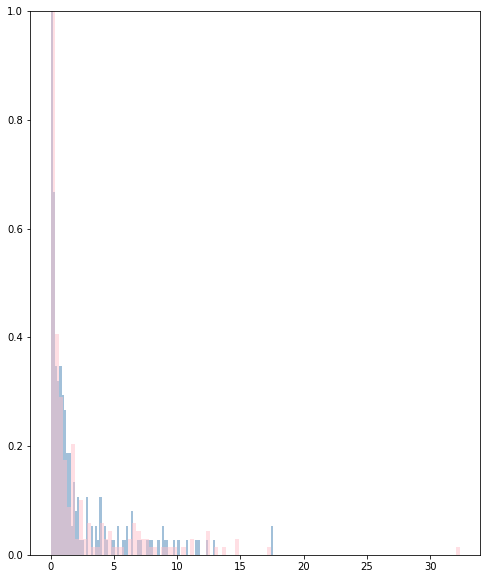

In [19]:
#######################################
##Exercise 1C: plot histograms and compare the distribution of erosion between 1995-2005 and 1975-1985
#######################################
fig, ax= plt.subplots()
fig.set_size_inches(10,10)
fig.subplots_adjust(right=0.75)
ax.hist(CE_1975_1985, bins=100, normed=True, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
ax.hist(CE_1995_2005, bins=100, normed=True, alpha=0.5,
         histtype='stepfilled', color='pink',
         edgecolor='none')
ax.set_ylim([0.,1.])
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir)) 
#plt.close()

2)	Plot a worldmap of C erosion rates

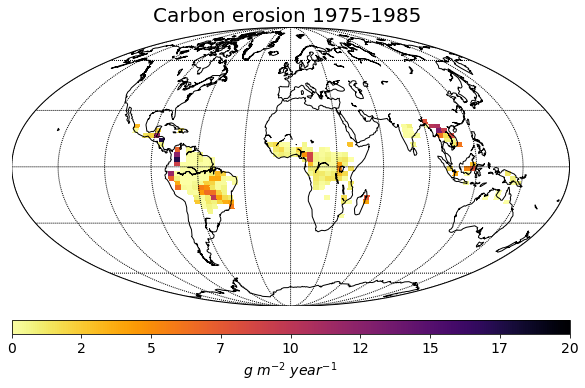

In [20]:
data=(CE0/10.).reshape(rows,kols)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
m=Basemap(projection='moll',resolution='c', lon_0=0, llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=75.)
m.drawcoastlines()
m.drawparallels(np.arange(-60.,75.,30))
m.drawmeridians(np.arange(-180.,180.,30))
x,y=m(llons,llats)
cmap=plt.cm.inferno_r
data=np.ma.masked_where(data==0.,data)
cmap.set_bad('white')
cs=m.pcolormesh(x,y,data,vmin=0.,vmax=20.,cmap=cmap)
plt.title('Carbon erosion 1975-1985 ',fontsize=20)
cbar = m.colorbar(cs,location='bottom',pad="5%",format='%i')
cbar.set_label('$g$ $m^{-2}$ $year^{-1}$',fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.show()
#plt.savefig('%s/output/figure.png' %(workdir))  
#plt.close()

3)	Investigate the spatial relationship between soil erosion and C erosion  

a.	First we need to remap the high-resolution soil erosion rates to the coarse resolution of  the carbon erosion rates. For this we need to import the regrid tool in the PythonTools folder. We do this as following:  
For Windows:  
Copy the folder PythonTools to the ‘sitepackages’ directory in Anaconda. In my case it is: C:\Users\adminuser\Anaconda2\Lib\site-packages  
For linux:  
In the Cerosion_analysis.py file add the following 2 lines at the beginning of the script before importing numpy:   
import sys  
sys.path.insert(0,' path to PythonTools folder') 

b.	Execute the last part of the Cerosion_analysis.py  
Look at the regression relationship by printing the variable p or p0. The output is the coefficient and slope of the linear regression  


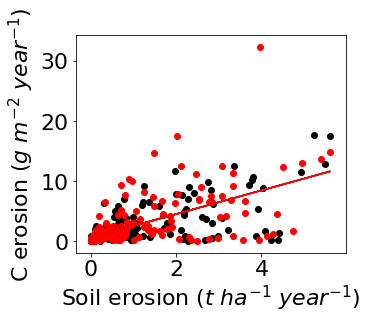

In [21]:
CE0=0.;CE1=0.
for y in range(1975,1985):
  #print y
  #erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,y),'r')
  CE = np.array(data.variables['E'][:]) #g/m2
  CE[clim!=clim_sel]=0.  
  CE0+=np.ravel(CE) #g/m2/y  
  data.close()
for y in range(1995,2005):
  #print y
  #erosion CC + LUC
  data = Dataset('%s/input/SOC_data/Em_CE_cc_luc_crop_%04i.nc' % (workdir,y),'r')
  CE = np.array(data.variables['E'][:]) #g/m2
  CE[clim!=clim_sel]=0.  
  CE1+=np.ravel(CE) 
  data.close()

E0=0.;E1=0.
for y in range(1975,1985):
  #print y
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_zone%s.nc' % (workdir,y,clim_class[clim_sel-1]),'r')
  E = np.array(data.variables['E'][:,:-2])
  E[E>20.]=20. #exclude unrealistic values
  E0+=E #t/ha/y  
  data.close()
for y in range(1995,2005):
  #print y
  #erosion CC + LUC
  data = Dataset('%s/output/erosion/E_crop_%04i_zone%s.nc' % (workdir,y,clim_class[clim_sel-1]),'r')
  E = np.array(data.variables['E'][:,:-2])
  E[E>20.]=20.
  E1+=E
  data.close()
E_1975_1985=E0/10.;E_1995_2005=E1/10.

data0=1.*E_1975_1985
data0[np.isnan(data0)==True]=0.

data0=np.ma.vstack((np.ma.masked_all((48,4320)),data0,np.ma.masked_all((432,4320)))) # fill pixels (0.083 in lat) north of 83.9917 and pixels south of -55.9523
data0_aggr=regrid(data0[:],[90.,-90.],1./12.,[90.,-90.],2.5,1/12.,[-180.,180.],1./12.,[-180.,180.],3.75,1/24.,'d','d',True,True,True,1)

E0_data=1*np.ravel(data0_aggr[:61,:-1])
CE0_data=(CE0/10.)
E0_data[E0_data==0.]=np.nan
CE0_data[CE0_data==0.]=np.nan
E0_data[np.isnan(CE0_data)==True]=np.nan
CE0_data[np.isnan(E0_data)==True]=np.nan
E0_data=E0_data[np.isnan(E0_data)==False]
CE0_data=CE0_data[np.isnan(CE0_data)==False]

data=1.*E_1995_2005
data[np.isnan(data)==True]=0.

data=np.ma.vstack((np.ma.masked_all((48,4320)),data,np.ma.masked_all((432,4320)))) # fill pixels (0.083 in lat) north of 83.9917 and pixels south of -55.9523
data_aggr=regrid(data[:],[90.,-90.],1./12.,[90.,-90.],2.5,1/12.,[-180.,180.],1./12.,[-180.,180.],3.75,1/24.,'d','d',True,True,True,1)

E_data=1*np.ravel(data_aggr[:61,:-1])
CE_data=(CE1/10.)
E_data[E_data==0.]=np.nan
CE_data[CE_data==0.]=np.nan
E_data[np.isnan(CE_data)==True]=np.nan
CE_data[np.isnan(E_data)==True]=np.nan
E_data=E_data[np.isnan(E_data)==False]
CE_data=CE_data[np.isnan(CE_data)==False]

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)
z0 = np.polyfit(E0_data,CE0_data, 1)
z = np.polyfit(E_data,CE_data, 1)
p0=np.poly1d(z0)
p=np.poly1d(z)
ax.plot(E0_data, p(E0_data), 'k-')
ax.plot(E_data, p(E_data), 'r-')
ax.scatter(E0_data,CE0_data,color='k')
ax.scatter(E_data,CE_data,color='r')
ax.set_xlabel('Soil erosion ($t$ $ha^{-1}$ $year^{-1}$)',fontsize=22)
ax.set_ylabel('C erosion ($g$ $m^{-2}$ $year^{-1}$)',fontsize=22)
ax.tick_params(axis='y',labelsize=22)
ax.tick_params(axis='x',labelsize=22)
#ax.legend(loc='upper left',fontsize=20)
plt.show()


In [22]:
p

poly1d([1.96723663, 0.56160065])

In [23]:
p0

poly1d([1.7504663 , 0.43123903])